In [2]:
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt
from keras import layers

2024-07-03 20:51:16.544395: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-03 20:51:16.575773: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-03 20:51:17.037429: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [11]:
#Coletando dados 

df = pd.read_excel('/home/andre/Downloads/RJ_Reconstrucao_Moluscos_2024_06_25.xlsx')
df_TOTAL_MOLLUSCS = pd.DataFrame(df[['Ano','TOTAL_MOLLUSCS']])

dados = df_TOTAL_MOLLUSCS.dropna()
anos_com_dados = dados["Ano"].values
anos_para_prever = np.array([1950,1951,1952,1953,1954,1955,1990,1991,1992,1993,1994,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022])
todos_anos = np.concatenate((anos_para_prever, anos_com_dados))
todos_anos.sort()

pesca = dados['TOTAL_MOLLUSCS'].values

In [13]:
#Normalização dos dados

ano_mean = np.mean(anos_com_dados)
ano_std = np.std(anos_com_dados)
anos_para_prever_norm = (anos_para_prever - ano_mean)/ano_std
anos_com_dados_norm = (anos_com_dados - ano_mean)/ano_std

pesca_mean = np.mean(pesca)
pesca_std = np.std(pesca)
pesca_norm = (pesca - pesca_mean)/pesca_std

In [7]:
#Fit do modelo e salvando seus pesos
model = keras.Sequential([layers.Dense(96,activation='leaky_relu',input_shape=(1,)),
                             layers.Dense(32,activation='leaky_relu'),
                             layers.Dense(80,activation='leaky_relu'),
                             layers.Dense(80,activation='leaky_relu'),
                             layers.Dense(96,activation='leaky_relu'),
                             layers.Dense(112,activation='leaky_relu'),
                             layers.Dense(1,activation='linear')])

opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='mse')


#history = model.fit(anos_com_dados_norm,pesca_norm, epochs=800, verbose=1)
#model.save_weights('/home/andre/Área de Trabalho/Projeto da pesca/Rio de Janeiro/Moluscos/pesos pesca total/.weights.h5', overwrite=True)

/home/andre/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
#Pegando os pesos salvos
model.load_weights('/home/andre/Área de Trabalho/Projeto da pesca/Rio de Janeiro/Moluscos/pesos pesca total/.weights.h5')

/home/andre/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Previsões dos dados ausentes: [[  34.274323]
 [  40.03427 ]
 [  45.418457]
 [  45.975098]
 [  41.93802 ]
 [  36.598267]
 [ 250.78053 ]
 [ 253.57596 ]
 [ 276.7943  ]
 [ 320.68286 ]
 [ 385.32248 ]
 [1418.5659  ]
 [1469.6295  ]
 [1515.3223  ]
 [1555.7761  ]
 [1593.658   ]
 [1631.3137  ]
 [1669.0669  ]
 [1706.4583  ]
 [1740.9316  ]
 [1775.6047  ]
 [1810.353   ]
 [1844.5215  ]
 [1878.3647  ]
 [1912.0994  ]
 [1945.3796  ]]


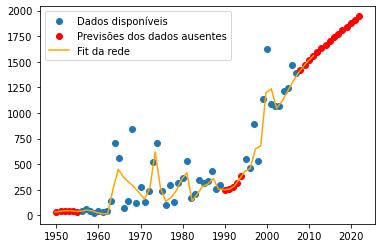

In [14]:
#Previsões
prev_disponiveis = model.predict(anos_com_dados_norm)*pesca_std + pesca_mean
prev_ausentes = model.predict(anos_para_prever_norm)*pesca_std + pesca_mean

#Colocando valores negativos para 0
for i in range(len(prev_ausentes)):
    if prev_ausentes[i]<0:
        prev_ausentes[i]=0

#Plot dos dados e previsões
f1=plt.figure(1).add_subplot()
f1.scatter(anos_com_dados,pesca,label='Dados disponíveis')
f1.scatter(anos_para_prever,prev_ausentes, color='red', label='Previsões dos dados ausentes')

#Plot do fit da rede
p = np.linspace(-2,2,50)
y = model.predict(p)*pesca_std + pesca_mean
f1.plot(p*ano_std + ano_mean,y,color='orange',label='Fit da rede')

#Print das previsões
print('Previsões dos dados ausentes:', prev_ausentes)


plt.legend()
plt.show()

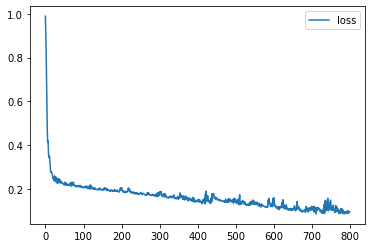

In [70]:
loss = history.history['loss']
plt.plot(loss,label='loss')
plt.legend()
plt.show()

In [18]:
#Planilha com os dados preenchidos

df_previsoes = pd.DataFrame({'Ano':anos_para_prever, 'TOTAL_MOLLUSCS':prev_ausentes.flatten()})

df_preenchido = pd.concat((dados,df_previsoes)).sort_values('Ano')
df_preenchido = df_preenchido.set_index('Ano')

with pd.option_context('display.max_rows', None,):
    print(df_preenchido)

df_preenchido.to_excel('/home/andre/Área de Trabalho/Previsão TOTAL_MOLLUSCS.xlsx')

      TOTAL_MOLLUSCS
Ano                 
1950       34.274323
1951       40.034271
1952       45.418457
1953       45.975098
1954       41.938019
1955       36.598267
1956       43.670000
1957       64.000000
1958       44.000000
1959       23.000000
1960       43.000000
1961       36.000000
1962       38.000000
1963      141.000000
1964      708.000000
1965      560.000000
1966       75.000000
1967      145.000000
1968      843.000000
1969      125.000000
1970      277.000000
1971      133.000000
1972      241.000000
1973      526.000000
1974      704.000000
1975      238.000000
1976      103.000000
1977      292.000000
1978      131.000000
1979      314.000000
1980      368.000000
1981      527.000000
1982      171.000000
1983      206.000000
1984      344.000000
1985      313.000000
1986      339.000000
1987      436.000000
1988      260.000000
1989      297.000000
1990      250.780533
1991      253.575958
1992      276.794312
1993      320.682861
1994      385.322479
1995      554